In [2]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
import os
import seaborn as seaborn
import math
import datetime
from folium.plugins import BeautifyIcon
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from ipywidgets import interact, Dropdown
from shapely.geometry import Point

In [3]:
train_data = pd.read_csv('japan_2000_2023_query.csv')
train_df = train_data[["time", "place", "latitude", "longitude", "depth", "mag"]]
train_df = train_df[~train_df['place'].str.contains("Russia", na = False)] # remove Russia
train_df = train_df[~train_df['place'].str.contains("China", na = False)] # remove China 
train_df = train_df[~train_df['place'].str.contains("Korea", na = False)] # remove Korea
train_df['time'] = pd.to_datetime(train_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
print(train_df.head())
train_df.to_csv('clean_japan_2000_2023.csv', index=False)

## for more information about magnetude types, please refer to https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types?qt-science_center_objects=0#qt-science_center_objects


                  time                          place  latitude  longitude  \
0  2023-03-02 07:19:01      135 km S of Shing?, Japan   32.5313   135.7405   
1  2023-03-02 06:47:39   157 km SSE of Shimoda, Japan   33.3315   139.4942   
3  2023-02-28 15:48:02       7 km SW of Hasaki, Japan   35.6762   140.7823   
4  2023-02-28 11:12:09  272 km SSE of Katsuura, Japan   32.9764   141.6939   
5  2023-02-28 03:55:10     17 km NNE of Hasaki, Japan   35.8699   140.9309   

    depth  mag  
0  16.123  4.5  
1   9.945  5.1  
3  43.894  4.5  
4  10.000  5.2  
5  46.248  4.7  


In [4]:
# volcano dataframe creation
volcano_data = pd.read_csv('Active_Volcanoes.csv')
volcano_df = volcano_data[["Name", "Latitude", "Longitude", "Region", "Active"]]

In [5]:
# Visualization of significant Earthquakes in Japan from 2001 through 2018
major_cities = [
    {"name": "Tokyo", "latitude": 35.6895, "longitude": 139.6917},
    {"name": "Osaka", "latitude": 34.6937, "longitude": 135.5023},
    {"name": "Kyoto", "latitude": 35.0116, "longitude": 135.7681},
    {"name": "Nagoya", "latitude": 35.1815, "longitude": 136.9066},
    {"name": "Sapporo", "latitude": 43.0618, "longitude": 141.3545},
    {"name": "Fukuoka", "latitude": 33.5904, "longitude": 130.4017},
    {"name": "Hiroshima", "latitude": 34.3853, "longitude": 132.4553},
    {"name": "Sendai", "latitude": 38.2682, "longitude": 140.8694},
    
]

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    import math
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2024)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        circle_color = get_color(earthquake['mag'])
        circle_radius = calculate_radius(earthquake['mag'])  # Calculate radius based on magnitude
        folium.Circle(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=circle_radius, 
            color=circle_color, 
            fill=True,
            fill_color=circle_color,
            tooltip=tooltip_info
        ).add_to(earthquake_map)

    for city in major_cities:
        folium.Marker(
            location=[city['latitude'], city['longitude']],
            popup=city['name'],
            icon=folium.Icon(icon="star", color="blue")
        ).add_to(earthquake_map)

    # Aggiungere una legenda personalizzata
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))

    # Mostrare la mappa
    display(earthquake_map)

    


interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …

In [6]:
# Heatmap

earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)
heat_data = [[row['latitude'], row['longitude'], row['mag']] for index, row in train_df.iterrows()]

#Add the heat map to the map
HeatMap(heat_data).add_to(earthquake_map)
earthquake_map

In [7]:
# Clustered Map

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2019)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    marker_cluster = MarkerCluster().add_to(earthquake_map)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        folium.CircleMarker(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=5,  # Fixed radius for better clustering visualization
            color=get_color(earthquake['mag']), 
            fill=True,
            fill_color=get_color(earthquake['mag']),
            tooltip=tooltip_info
        ).add_to(marker_cluster)

    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))

    # Mostrare la mappa

    display(earthquake_map)

interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …

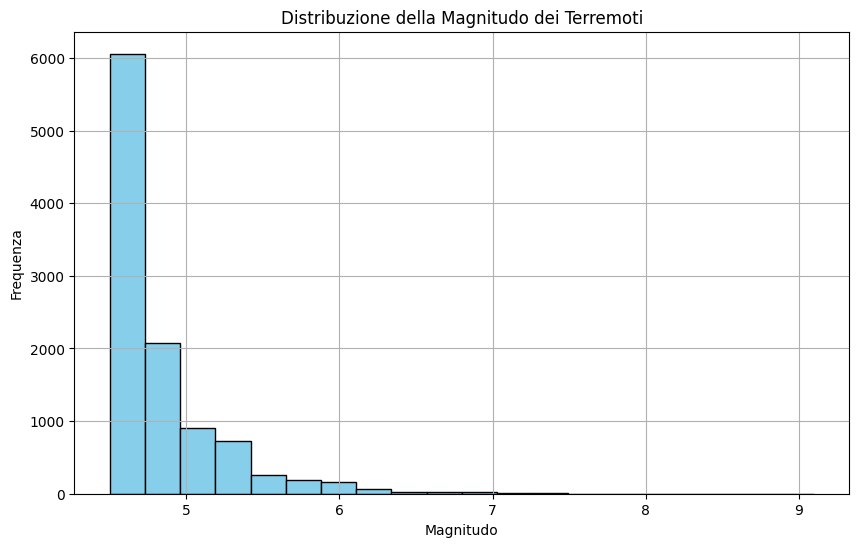

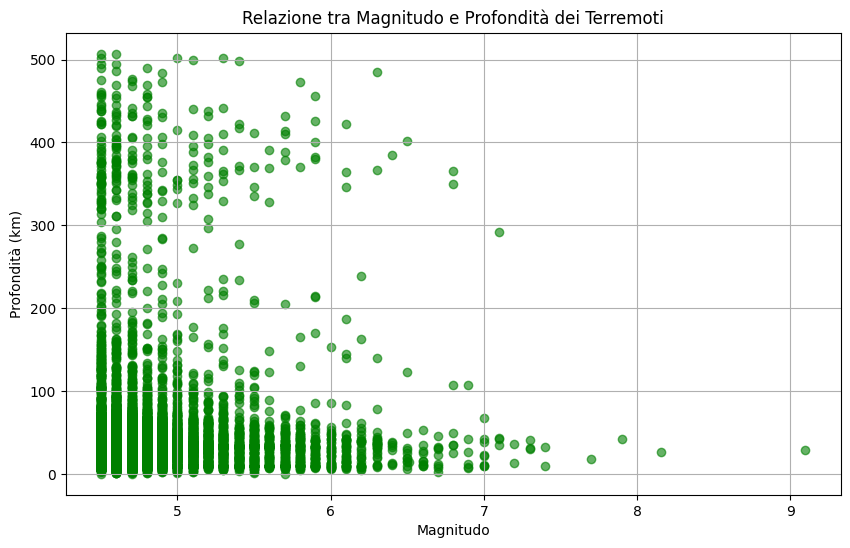

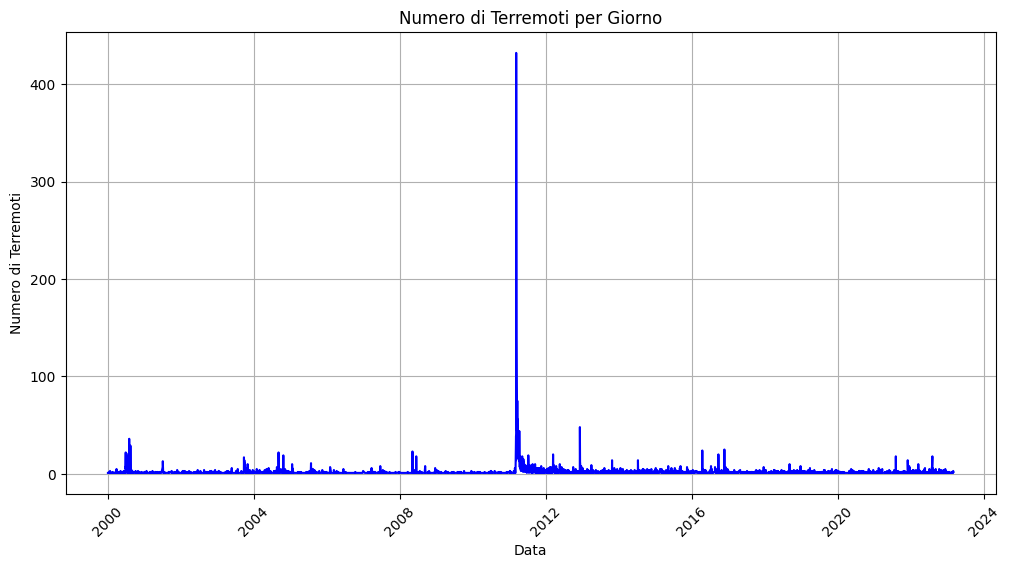

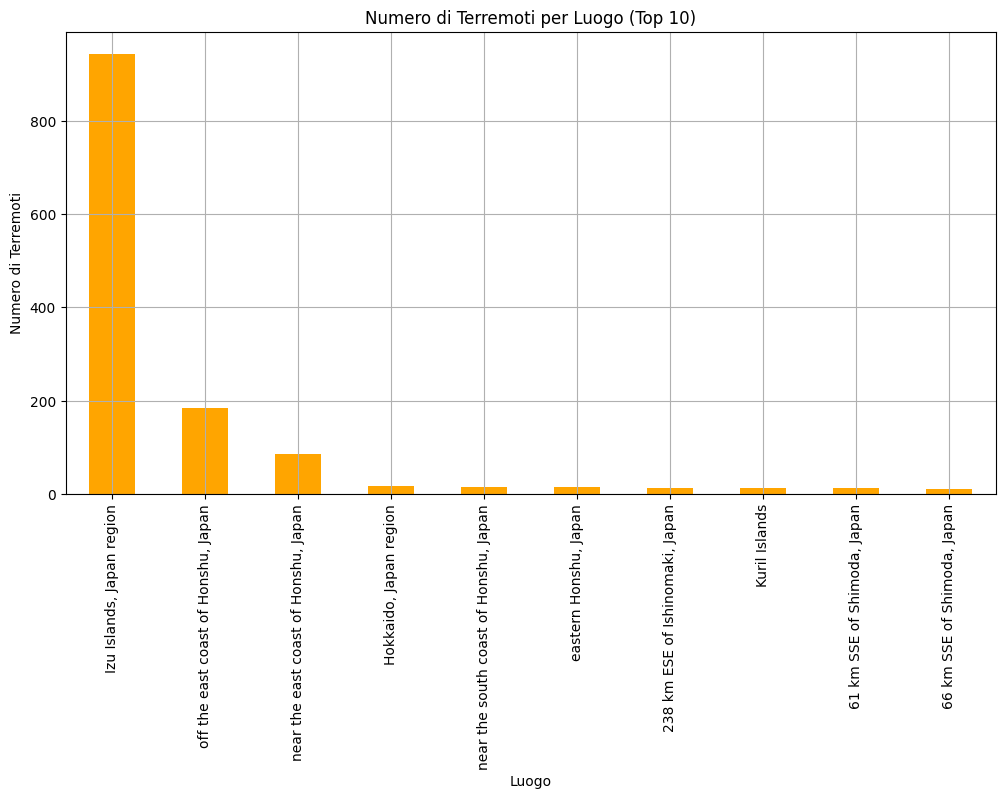

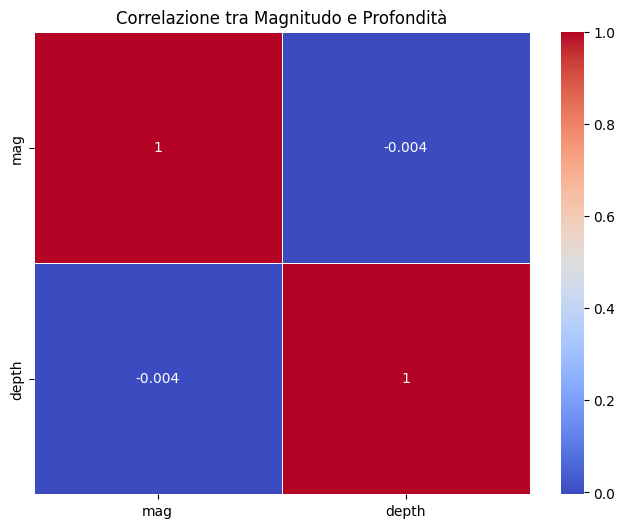

In [8]:
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)


# Istogramma magnitudo dei terremoti
plt.figure(figsize=(10, 6))
plt.hist(train_df['mag'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuzione della Magnitudo dei Terremoti')
plt.xlabel('Magnitudo')
plt.ylabel('Frequenza')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'istogramma_magnitudo.png'))  # Salva l'immagine



# Scatter plot tra Magnitudo e Profondità
plt.figure(figsize=(10, 6))
plt.scatter(train_df['mag'], train_df['depth'], alpha=0.6, color='green')
plt.title('Relazione tra Magnitudo e Profondità dei Terremoti')
plt.xlabel('Magnitudo')
plt.ylabel('Profondità (km)')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_magnitudo_profondita.png'))  # Salva l'immagine




# Converti la colonna 'time' in formato datetime
train_df['time'] = pd.to_datetime(train_df['time'])

# Conteggio dei terremoti per giorno
earthquake_by_day = train_df.groupby(train_df['time'].dt.date).size()

# Plot del numero di terremoti nel tempo
plt.figure(figsize=(12, 6))
plt.plot(earthquake_by_day.index, earthquake_by_day.values, color='blue')
plt.title('Numero di Terremoti per Giorno')
plt.xlabel('Data')
plt.ylabel('Numero di Terremoti')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'terremoti_per_giorno.png'))  # Salva l'immagine




# Conteggio dei terremoti per luogo
earthquake_by_place = train_df['place'].value_counts().head(10)  # I primi 10 luoghi con più terremoti

# Bar plot dei terremoti per luogo
plt.figure(figsize=(12, 6))
earthquake_by_place.plot(kind='bar', color='orange')
plt.title('Numero di Terremoti per Luogo (Top 10)')
plt.xlabel('Luogo')
plt.ylabel('Numero di Terremoti')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'terremoti_per_luogo.png'))  # Salva l'immagine




# Calcolare la correlazione
correlation = train_df[['mag', 'depth']].corr()

# Heatmap della correlazione
plt.figure(figsize=(8, 6))
seaborn.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlazione tra Magnitudo e Profondità')
plt.savefig(os.path.join(output_dir, 'correlazione_heatmap.png'))  # Salva l'immagine




In [9]:
# GeoPandas
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

major_cities = {
    'Tokyo': [35.6762, 139.6503],
    'Osaka': [34.6937, 135.5023],
    'Kyoto': [35.0116, 135.7681],
    'Nagoya': [35.1815, 136.9066],
    'Sapporo': [43.0618, 141.3545],
    'Fukuoka': [33.5902, 130.4017],
    'Hiroshima': [34.3853, 132.4553],
    'Sendai': [38.2682, 140.8694],
    'Muroto (Kochi)': [33.3714, 134.1431]
}

geometry = [Point(xy) for xy in zip(train_df['longitude'], train_df['latitude'])]
geo_df = gpd.GeoDataFrame(train_df, crs={'init': 'epsg:4326'}, geometry=geometry)

# prepare data for clustering and performing DBSCAN clustering on data
coords = np.column_stack((geo_df['latitude'], geo_df['longitude']))
coords_scaled = StandardScaler().fit_transform(coords)

# db = DBSCAN(eps=0.5, min_samples=10).fit(coords_scaled)
# geo_df['cluster'] = db.labels_

# calculating risk scores for major cities

risk_scores = {}

for city, coords in major_cities.items():

    city_point = Point(coords[1], coords[0])
    nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]

    if(len(nearby_eqs) > 0):
        distances = nearby_eqs.geometry.distance(city_point)
        risk_score = sum(nearby_eqs['mag'] / (1 + distances))
        normalized_score = np.log1p(risk_score)

    else:
        normalized_score = 0

    risk_scores[city] = normalized_score

print(risk_scores)

# Visualization of significant Earthquakes in Japan from 2001 through 2018
major_cities = [
    {"name": "Tokyo", "latitude": 35.6895, "longitude": 139.6917},
    {"name": "Osaka", "latitude": 34.6937, "longitude": 135.5023},
    {"name": "Kyoto", "latitude": 35.0116, "longitude": 135.7681},
    {"name": "Nagoya", "latitude": 35.1815, "longitude": 136.9066},
    {"name": "Sapporo", "latitude": 43.0618, "longitude": 141.3545},
    {"name": "Fukuoka", "latitude": 33.5904, "longitude": 130.4017},
    {"name": "Hiroshima", "latitude": 34.3853, "longitude": 132.4553},
    {"name": "Sendai", "latitude": 38.2682, "longitude": 140.8694},
    {"name": "Muroto (Kochi)", "latitude": 33.3714, "longitude": 134.1431}
]

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'
    
def calculate_radius(magnitude):
    # formula: area ~ 10^(magnitude - 5) km^2
    # visualizing estimated area as a circle: r ~ sqrt(area / pi)
    import math
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

# Function to update the map with filters
@interact(year=Dropdown(options=['All'] + list(range(2001, 2024)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filter earthquakes by year and minimum magnitude
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Create the map
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    # Add circles to the map
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        circle_color = get_color(earthquake['mag'])
        circle_radius = calculate_radius(earthquake['mag'])  # Calculate radius based on magnitude
        folium.Circle(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=circle_radius, 
            color=circle_color, 
            fill=True,
            fill_color=circle_color,
            tooltip=tooltip_info
        ).add_to(earthquake_map)

    for city in major_cities:
        tooltip_info2 = f"City: {city['name']}<br>Risk Score: {risk_scores[city['name']]:.2f}"
        folium.Marker(
            location=[city['latitude'], city['longitude']],
            popup=city['name'],
            icon=folium.Icon(icon="star", color="blue"),
            tooltip=tooltip_info2
        ).add_to(earthquake_map)

    # Aggiungere una legenda personalizzata
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 150px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))
    heat_data = [[row['latitude'], row['longitude'], row['mag']] for index, row in train_df.iterrows()]

    #Add the heat map to the map
    HeatMap(heat_data).add_to(earthquake_map)

    prefectures = gpd.read_file('japan_prefectures.geojson')
    folium.GeoJson(
        prefectures,
        name='Prefectures',
        style_function=lambda feature: {
            'fillColor': 'white',
            'color': 'white',
            'weight': 2,
            'fillOpacity': 0.01
    }
    ).add_to(earthquake_map)

    # Mostrare la mappa
    display(earthquake_map)

    # TODO: remove or change the Risk Score: it's too based on magnitude (see Sendai which has a great outlier which greatly increases the risk score)
    # other than that, the risk score is not very useful as it is now since it just calculates said score based on 2000-2023 data, which is not enough to make a predictio


c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878483560.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]
C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878483560.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distan

{'Tokyo': 8.357271623877548, 'Osaka': 5.764315493223879, 'Kyoto': 5.789313678713137, 'Nagoya': 6.042612610453963, 'Sapporo': 6.768407207606119, 'Fukuoka': 5.875230142973518, 'Hiroshima': 5.3749805396687185, 'Sendai': 8.568435755897442, 'Muroto (Kochi)': 5.021710439026916}


C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878483560.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]
C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878483560.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = nearby_eqs.geometry.distance(city_point)
C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878483560.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_eqs = geo_df[geo_df.geometry.distance(city_point) < 2.0]
C:\Users\antho\AppData\Local\Temp\ipykernel_31172\1878

interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …

In [15]:
from folium.plugins import HeatMap
from ipywidgets import interact, Dropdown
import folium

def get_color(magnitude):
    if magnitude < 5.0:
        return 'orange'
    elif 5.0 <= magnitude < 7.0:
        return 'red'
    else:
        return 'darkred'

def calculate_radius(magnitude):
    import math
    area = 10 ** (magnitude - 5)
    radius_km = math.sqrt(area / math.pi) * 1000
    return radius_km

def calculate_event_periodicity(earthquakes_df, point, max_distance=100):
    nearby_quakes = earthquakes_df[earthquakes_df.apply(
        lambda row: distance([row['latitude'], row['longitude']], point) < max_distance, axis=1
    )]
    
    if len(nearby_quakes) < 2:
        return 0
    
    # Ordina per tempo e calcola gli intervalli
    nearby_quakes = nearby_quakes.sort_values('time')
    # Ensure 'time' is in datetime format first
    nearby_quakes['time'] = pd.to_datetime(nearby_quakes['time'])

    # Then calculate time differences in days
    time_diffs = np.diff(nearby_quakes['time']).astype('timedelta64[D]')
    # Convert time differences to numeric values representing days
    time_diffs_in_days = time_diffs.astype(float)  # Convert timedelta64[D] to float (days)

    # Now calculate the mean and standard deviation of the time differences
    mean_interval = np.mean(time_diffs_in_days)
    std_interval = np.std(time_diffs_in_days)
    
    # Frequenza = eventi/anno
    frequency = 365.25 / mean_interval if mean_interval > 0 else 0
    # Regolarità = inverso della deviazione standard normalizzata
    regularity = 1 / (1 + std_interval/mean_interval) if mean_interval > 0 else 0
    
    return frequency * regularity

def calculate_earthquake_risk(point, earthquakes_df, max_distance=100):
    nearby_quakes = earthquakes_df[earthquakes_df.apply(
        lambda row: distance([row['latitude'], row['longitude']], point) < max_distance, axis=1
    )]
    
    if len(nearby_quakes) == 0:
        return 0
    
    distances = nearby_quakes.apply(
        lambda row: distance([row['latitude'], row['longitude']], point), axis=1
    )
    
    # Calcolo componenti di rischio
    magnitude_risk = sum(nearby_quakes['mag'] / (distances + 1))
    depth_risk = sum(1 / (nearby_quakes['depth'] + 1) / (distances + 1))
    periodicity_risk = calculate_event_periodicity(earthquakes_df, point)
    
    # Pesi delle componenti
    risk_score = (
        0.4 * magnitude_risk + 
        0.3 * depth_risk + 
        0.3 * periodicity_risk
    )
    
    return np.log1p(risk_score)


def calculate_volcano_risk(point, volcano_df, max_distance=50):
    active_volcanoes = volcano_df[volcano_df['Active'] == 'Yes']
    if len(active_volcanoes) == 0:
        return 0
        
    distances = active_volcanoes.apply(
        lambda row: distance([row['Latitude'], row['Longitude']], point), axis=1
    )
    
    risk_score = sum(1 / (distances + 1))
    return np.log1p(risk_score)

def calculate_total_risk(point, earthquakes_df, volcano_df):
    eq_risk = calculate_earthquake_risk(point, earthquakes_df)
    vol_risk = calculate_volcano_risk(point, volcano_df)
    
    # Aumentato peso attività sismica
    return 0.85 * eq_risk + 0.15 * vol_risk

def distance(p1, p2):
    from math import sin, cos, sqrt, atan2, radians
    R = 6371  # Earth's radius in km
    
    lat1, lon1 = map(radians, p1)
    lat2, lon2 = map(radians, p2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

@interact(year=Dropdown(options=['All'] + list(range(2001, 2024)), value='All', description="Year:"), 
          min_magnitude=(3.0, 9.0, 0.1))
def update_map(year='All', min_magnitude=5.5):
    # Filtra i terremoti per anno e magnitudo minima
    if year == 'All':
        filtered_earthquakes = train_df[train_df['mag'] >= min_magnitude]
    else:
        filtered_earthquakes = train_df[(train_df['mag'] >= min_magnitude) & (pd.to_datetime(train_df['time']).dt.year == year)]

    # Crea la mappa
    earthquake_map = folium.Map(location=[37.973265, 142.597713], zoom_start=5, tiles="CartoDB positron", width=1250)

    # Aggiungi i cerchi per i terremoti
    for idx, earthquake in filtered_earthquakes.iterrows():
        tooltip_info = f"Time: {earthquake['time']}<br>Place: {earthquake['place']}<br>Magnitude: {earthquake['mag']}"
        circle_color = get_color(earthquake['mag'])
        circle_radius = calculate_radius(earthquake['mag'])
        folium.Circle(
            location=[earthquake['latitude'], earthquake['longitude']], 
            radius=circle_radius, 
            color=circle_color, 
            fill=True,
            fill_color=circle_color,
            tooltip=tooltip_info,
    ).add_to(earthquake_map)

    # Layer per i vulcani
    volcano_layer = folium.FeatureGroup(name='Volcanoes', show=False)
    for idx, volcano in volcano_df.iterrows():
        tooltip_info = f"Name: {volcano['Name']} <br>Region: {volcano['Region']}<br>Active: {volcano['Active']}"
        folium.Marker(
            location=[volcano['Latitude'], volcano['Longitude']],
            popup=volcano['Name'],
            icon=folium.Icon(icon="fire", color="purple"),
            tooltip=tooltip_info
        ).add_to(volcano_layer)
    volcano_layer.add_to(earthquake_map)

    # Layer per la HeatMap
    heatmap_layer = folium.FeatureGroup(name='HeatMap', show=False)
    heat_data = [[row['latitude'], row['longitude'], row['mag']] for _, row in train_df.iterrows()]
    HeatMap(heat_data).add_to(heatmap_layer)
    heatmap_layer.add_to(earthquake_map)

    # Aggiungi una legenda personalizzata
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 250px; height: 200px; 
                background-color: white; z-index:9999; font-size:14px; 
                border:2px solid grey; padding: 10px;">
        <b>Magnitude Legend:</b><br>
        <i style="background: orange; color: orange;">&nbsp;&nbsp;&nbsp;&nbsp;</i> < 5.0<br>
        <i style="background: red; color: red;">&nbsp;&nbsp;&nbsp;&nbsp;</i> 5.0 - 6.9<br>
        <i style="background: darkred; color: darkred;">&nbsp;&nbsp;&nbsp;&nbsp;</i> >= 7.0<br>
        <br><b>Other:</b><br>
        <i style="color: purple;" class="fa fa-map-marker"></i> Active Volcano
    </div>
    '''
    earthquake_map.get_root().html.add_child(folium.Element(legend_html))

    # Aggiungi le prefetture del Giappone
    prefectures = gpd.read_file('japan_prefectures.geojson')
    folium.GeoJson(
        prefectures,
        name='Prefectures',
        style_function=lambda feature: {
            'fillColor': 'white',
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0.01
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['nam'],  
            aliases=['Prefecture:'],  
            localize=False
        )
    ).add_to(earthquake_map)


    # Calcola e visualizza il rischio per le prefetture
    risk_data = []
    for idx, prefecture in prefectures.iterrows():
        centroid = prefecture.geometry.centroid.coords[0]
        point = [centroid[1], centroid[0]]  # [lat, lon]
        risk = calculate_total_risk(point, filtered_earthquakes, volcano_df)
        risk_data.append(risk)

    prefectures['risk_score'] = risk_data

    folium.Choropleth(
        geo_data=prefectures,
        name='Seismic Risk',
        data=prefectures,
        columns=['id', 'risk_score'],
        key_on='feature.properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.5,
        line_opacity=0.2,
        legend_name='Risk Score'
    ).add_to(earthquake_map)

    # Aggiungi il controllo dei layer
    folium.LayerControl(collapsed=False).add_to(earthquake_map)

    # Mostra la mappa
    display(earthquake_map)


interactive(children=(Dropdown(description='Year:', options=('All', 2001, 2002, 2003, 2004, 2005, 2006, 2007, …